This is a model for exploratory analysis based on a tutorial from Giraffa, Iona Barbos.
The methodology is complete and logical in progression.

The data is based upon casino customer gaming monetary transactions. There are two levels of transactions, each
with a deposit and a withdrawal. 
L1 transactions are customer deposits to/withdrawal from their gaming account.
L2 transactions are deposits to/withdrawals from the patron gaming account for gaming activities

Load libraries

In [2]:
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None
from datetime import datetime as dt
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio


Tidy up data appearance

In [3]:
pd.options.display.float_format = '{:20.2f}'.format
pd.set_option('display.max_columns', 999)

Import the csv file

In [4]:
df = pd.read_csv('Online_casino_DIB.csv')
df.head()

,ReqTimeUTC,TransactionType,TransactionAmount,Status,AccountIdentifier
0,2019-07-05T05:02:28+0000,LOYALTYCARDDEBIT,10.00,APPROVED,customer1734
1,2019-07-05T05:26:00+0000,LOYALTYCARDDEBIT,10.00,APPROVED,customer1734
2,2019-07-05T04:54:35+0000,LOYALTYCARDCREDITCL,10.00,APPROVED,customer1734
3,2019-07-05T05:02:27+0000,LOYALTYCARDCREDITCL,10.00,APPROVED,customer1734
4,2019-07-05T05:25:59+0000,LOYALTYCARDCREDITCL,10.00,APPROVED,customer1734


Examine the shape, datatype and info for the df

In [5]:
df.shape

(138928, 5)

In [6]:
df.dtypes

ReqTimeUTC            object
TransactionType       object
TransactionAmount    float64
Status                object
AccountIdentifier     object
dtype: object

In [7]:
df.describe(exclude='float64')

,ReqTimeUTC,TransactionType,Status,AccountIdentifier
count,138928,138928,138928,138928
unique,138042,3,2,2361
top,2020-02-05T08:52:23+0000,LOYALTYCARDDEBIT,APPROVED,customer10
freq,7,70329,133520,2318


ReqTimeUTC is type obj so convert it to date time
ReqTimeUTC has a number of digits in the entry for the time. If we are not going to use time you can clean up the entry by stripping of the time component of the entry - see the code line in the markdown
ReqTimeUTC has date/time entries beyond 2020-02-29 so exclude those values
Data is being excluded so create new df

In [8]:
df_raw = df[df.ReqTimeUTC <= '2020-02-29 00:00:00+00:00']\
    .copy()

In [9]:
df_raw['ReqTimeUTC'] = pd.to_datetime(df_raw['ReqTimeUTC'])

If you don't want the time elements for future use you can remove them using the following code line

df_raw['ReqTimeUTC'] = df_raw['ReqTimeUTC'].dt.strftime('%Y-%m-%d')

In [10]:
df_raw.head()

,ReqTimeUTC,TransactionType,TransactionAmount,Status,AccountIdentifier
0,2019-07-05 05:02:28+00:00,LOYALTYCARDDEBIT,10.00,APPROVED,customer1734
1,2019-07-05 05:26:00+00:00,LOYALTYCARDDEBIT,10.00,APPROVED,customer1734
2,2019-07-05 04:54:35+00:00,LOYALTYCARDCREDITCL,10.00,APPROVED,customer1734
3,2019-07-05 05:02:27+00:00,LOYALTYCARDCREDITCL,10.00,APPROVED,customer1734
4,2019-07-05 05:25:59+00:00,LOYALTYCARDCREDITCL,10.00,APPROVED,customer1734


Check the Transaction type column
 Transactions labeled as “LOYALTYCARDDEBIT” are Level 2 deposits. 
 Transactions labeled as “LOYALTYCARDCREDIT” are Level 2 withdrawals. 
 Transactions labeled as “LOYALTYCARDCREDITCL” or “LOYALTYCARDCREDITACH” are Level 1 deposits 
 made via a card or ACH respectively.

Map
 LOYALTYCARDDEBIT = L2D
 LOYALTYCARDCREDIT = L2W
 LOYALTYCARDCREDITCL = L1D

In [11]:
df_raw.describe(exclude='float64')

,ReqTimeUTC,TransactionType,Status,AccountIdentifier
count,137857,137857,137857,137857
unique,NaN,3,2,2351
top,NaN,LOYALTYCARDDEBIT,APPROVED,customer10
freq,NaN,69795,132473,2294
mean,2019-08-22 03:05:44.556649216+00:00,NaN,NaN,NaN
min,2019-03-01 08:03:23+00:00,NaN,NaN,NaN
25%,2019-05-18 13:13:36+00:00,NaN,NaN,NaN
50%,2019-08-20 03:04:39+00:00,NaN,NaN,NaN
75%,2019-11-21 13:40:41+00:00,NaN,NaN,NaN
max,2020-02-28 23:54:14+00:00,NaN,NaN,NaN


In [12]:
df_raw['TransactionType'].unique()

array(['LOYALTYCARDDEBIT', 'LOYALTYCARDCREDITCL', 'LOYALTYCARDCREDIT'],
      dtype=object)

Map the shortforms into the df column

In [13]:
df_raw.TransactionType = df_raw.TransactionType\
    .map({'LOYALTYCARDDEBIT':'L2D','LOYALTYCARDCREDITCL':'L1D',
          'LOYALTYCARDCREDIT':'L2W'})

df_raw.head()

,ReqTimeUTC,TransactionType,TransactionAmount,Status,AccountIdentifier
0,2019-07-05 05:02:28+00:00,L2D,10.00,APPROVED,customer1734
1,2019-07-05 05:26:00+00:00,L2D,10.00,APPROVED,customer1734
2,2019-07-05 04:54:35+00:00,L1D,10.00,APPROVED,customer1734
3,2019-07-05 05:02:27+00:00,L1D,10.00,APPROVED,customer1734
4,2019-07-05 05:25:59+00:00,L1D,10.00,APPROVED,customer1734


Simplify the AccountIdentifier column by stripping off 'Customer' with regex

In [14]:
df_raw['AccountIdentifier'] = df_raw['AccountIdentifier']\
    .str.replace(r'^customer','',
                                                                      regex=True)
df_raw.head()

,ReqTimeUTC,TransactionType,TransactionAmount,Status,AccountIdentifier
0,2019-07-05 05:02:28+00:00,L2D,10.00,APPROVED,1734
1,2019-07-05 05:26:00+00:00,L2D,10.00,APPROVED,1734
2,2019-07-05 04:54:35+00:00,L1D,10.00,APPROVED,1734
3,2019-07-05 05:02:27+00:00,L1D,10.00,APPROVED,1734
4,2019-07-05 05:25:59+00:00,L1D,10.00,APPROVED,1734


Rename some of the columns to more useable form

In [15]:
df_raw.rename(columns= {'AccountIdentifier':'user', 'ReqTimeUTC':'date',
                        'TransactionAmount':'amount', 
                        'TransactionType':'type',
                        'Status':'status'},inplace=True)

df_raw.head()

,date,type,amount,status,user
0,2019-07-05 05:02:28+00:00,L2D,10.00,APPROVED,1734
1,2019-07-05 05:26:00+00:00,L2D,10.00,APPROVED,1734
2,2019-07-05 04:54:35+00:00,L1D,10.00,APPROVED,1734
3,2019-07-05 05:02:27+00:00,L1D,10.00,APPROVED,1734
4,2019-07-05 05:25:59+00:00,L1D,10.00,APPROVED,1734


Group data by users by user and type 
Create df for user type and define - user_type_
Plot

In [16]:
df_raw.groupby(['user', 'type']).count().reset_index()

,user,type,date,amount,status
0,1,L1D,438,438,438
1,1,L2D,444,444,444
2,1,L2W,2,2,2
3,10,L1D,1164,1164,1164
4,10,L2D,1130,1130,1130
...,...,...,...,...,...
4984,997,L2D,1,1,1
4985,998,L1D,2,2,2
4986,998,L2D,2,2,2
4987,999,L1D,2,2,2


In [17]:
user_type_ = df_raw.groupby(['user', 'type']).count()\
    .reset_index()

<Axes: xlabel='date', ylabel='Count'>

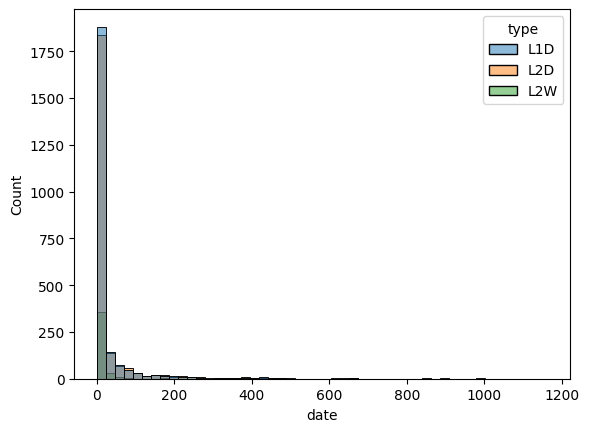

In [18]:
sns.histplot(data=user_type_, x='date', bins=50, 
             hue='type',)

Histplot even with hue is not very informative

<Axes: xlabel='date', ylabel='Density'>

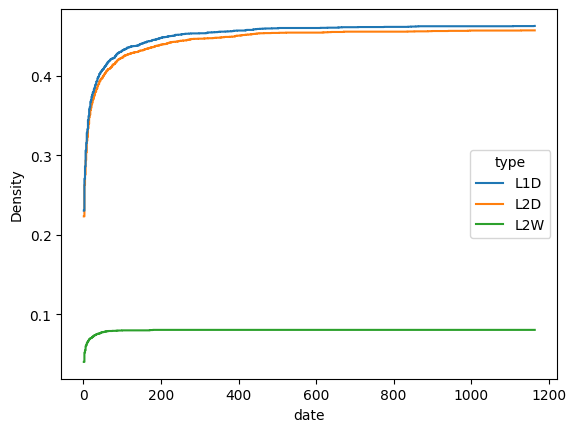

In [19]:
sns.histplot(data=user_type_, x='date', hue='type',
             cumulative=True, stat='density', 
             element='step', fill=False)

The cumulative version of the histplot is more informative.
L2D activities closely follows LD1 activities
There is more separation between the L#D activities and the L2W activities

In further analysis we will drop the L1D activities and keep on the L2D

In [20]:
df_working = df_raw.copy()
df_working.head(1)

,date,type,amount,status,user
0,2019-07-05 05:02:28+00:00,L2D,10.00,APPROVED,1734


In [21]:
df_working.columns

Index(['date', 'type', 'amount', 'status', 'user'], dtype='object')

In [22]:
df_working = df_working[(df_working.type == "L2D") & \
    (df_working.status == "APPROVED")].reset_index(drop=True)

df_working.shape

(69734, 5)

In [23]:
df_working = df_working[['user', 'date', 'type', 'amount']]

df_working = df_working.sort_values(['user', 'date'])\
    .reset_index(drop=True)

df_working.head()

,user,date,type,amount
0,1,2019-03-01 17:24:43+00:00,L2D,30.00
1,1,2019-03-01 19:54:04+00:00,L2D,50.00
2,1,2019-03-01 22:44:15+00:00,L2D,40.00
3,1,2019-03-02 02:44:20+00:00,L2D,100.00
4,1,2019-03-02 18:28:39+00:00,L2D,25.00


Check to see if the patrons who make the most frequent deposits also the patrons who deposit the most money.
Look at the data for the top 20 depositors
1. Get a frequency count
2. Reset the index
3. Select the first 2 columns
4. Sort by date, reversee the sort and take the top 20 values
5. Put the top 20 in a new df and clean it up

In [24]:
df_working.groupby('user').count()

,date,type,amount
user,,,
1,444,444,444
10,1130,1130,1130
100,56,56,56
1000,2,2,2
1001,23,23,23
...,...,...,...
995,6,6,6
996,3,3,3
997,1,1,1


In [25]:
df_working.groupby('user').count().reset_index()

,user,date,type,amount
0,1,444,444,444
1,10,1130,1130,1130
2,100,56,56,56
3,1000,2,2,2
4,1001,23,23,23
...,...,...,...,...
2275,995,6,6,6
2276,996,3,3,3
2277,997,1,1,1
2278,998,2,2,2


In [26]:
df_working.groupby('user').count().reset_index() \
    .iloc[:,0:2]

,user,date
0,1,444
1,10,1130
2,100,56
3,1000,2
4,1001,23
...,...,...
2275,995,6
2276,996,3
2277,997,1
2278,998,2


In [27]:
df_working.groupby('user').count().reset_index() \
    .iloc[:,0:2].sort_values("date")[::-1][0:20]

,user,date
1,10,1130
223,120,998
1462,26,992
1506,3,941
2236,96,900
1205,21,890
320,129,855
1895,65,837
1662,44,672
1507,30,671


In [28]:
df_top20_freq = df_working.groupby('user').count()\
    .reset_index()\
    .iloc[:,0:2].sort_values("date")[::-1][0:20]

Perform a similar activity for the top spenders

In [29]:
df_top20_spenders = df_working[['user', 'amount' ]] \
    .groupby('user').sum().reset_index()\
        .sort_values('amount') \
        [::-1][0:20]

In [30]:
df_top20_spenders.head()

,user,amount
977,189,401531.93
682,162,168295.00
1873,63,151583.00
1471,268,135528.95
1550,339,116869.90


Plot Top 20 side-by-side (ncols=2)

<Axes: xlabel='amount', ylabel='user'>

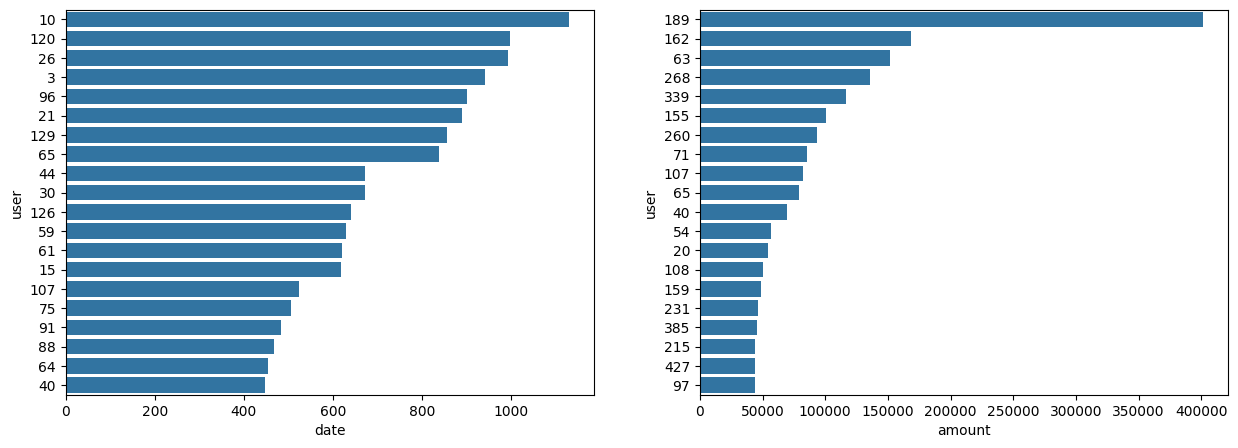

In [31]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 5))

sns.barplot(df_top20_freq, x='date', y='user', 
            ax = ax[0])
sns.barplot(df_top20_spenders, x='amount', 
            y='user', ax=ax[1])

The plot shows that the most frequent patrons are not the same as the patrons who deposit the most money


Work the date column to see what can extracted from it
Extract the hour from the date column
Extract the day of the week from the date column
Create new columns in the df for each of these elements
The day of the week is initiall presented as integers 0-6 Mon-Sun
Create dictionary to convert day of the week from int to day name and map to df

In [32]:
df_working.date.dt.hour
df_working['hour'] = df_working.date.dt.hour

In [33]:
df_working.date.dt.day_of_week
df_working['day_of_week'] = df_working.date.dt\
    .day_of_week
df_working

,user,date,type,amount,hour,day_of_week
0,1,2019-03-01 17:24:43+00:00,L2D,30.00,17,4
1,1,2019-03-01 19:54:04+00:00,L2D,50.00,19,4
2,1,2019-03-01 22:44:15+00:00,L2D,40.00,22,4
3,1,2019-03-02 02:44:20+00:00,L2D,100.00,2,5
4,1,2019-03-02 18:28:39+00:00,L2D,25.00,18,5
...,...,...,...,...,...,...
69729,997,2019-09-22 00:56:47+00:00,L2D,50.00,0,6
69730,998,2019-11-09 07:03:51+00:00,L2D,25.00,7,5
69731,998,2019-11-09 07:05:05+00:00,L2D,25.00,7,5
69732,999,2019-03-20 10:58:04+00:00,L2D,250.00,10,2


In [34]:
day_of_the_week_dict = {0: 'Monday',
                        1: 'Tuesday',
                        2: 'Wednesday',
                        3: 'Thursday',
                        4: 'Friday',
                        5: 'Saturday',
                        6: 'Sunday',
                        }

In [35]:
df_working['day_of_week'] = df_working['day_of_week']\
    .map(day_of_the_week_dict)
df_working

,user,date,type,amount,hour,day_of_week
0,1,2019-03-01 17:24:43+00:00,L2D,30.00,17,Friday
1,1,2019-03-01 19:54:04+00:00,L2D,50.00,19,Friday
2,1,2019-03-01 22:44:15+00:00,L2D,40.00,22,Friday
3,1,2019-03-02 02:44:20+00:00,L2D,100.00,2,Saturday
4,1,2019-03-02 18:28:39+00:00,L2D,25.00,18,Saturday
...,...,...,...,...,...,...
69729,997,2019-09-22 00:56:47+00:00,L2D,50.00,0,Sunday
69730,998,2019-11-09 07:03:51+00:00,L2D,25.00,7,Saturday
69731,998,2019-11-09 07:05:05+00:00,L2D,25.00,7,Saturday
69732,999,2019-03-20 10:58:04+00:00,L2D,250.00,10,Wednesday


Using the day and time of day data are there any patterns that are evident by plotting these data.
Create a heat map for this
Creating a heat map requires some manipulation of the data into a 'confusion matrix' where the day of the week is the index with the hours of the day as the columns of the matrix
Use the pivot table method from pandas to create the confusion matrix from the df we created

In [36]:
df_working[['hour', 'day_of_week', 'type']]\
    .groupby(['hour', 'day_of_week']).count().reset_index()

,hour,day_of_week,type
0,0,Friday,334
1,0,Monday,369
2,0,Saturday,385
3,0,Sunday,407
4,0,Thursday,323
...,...,...,...
163,23,Saturday,439
164,23,Sunday,346
165,23,Thursday,377
166,23,Tuesday,349


In [37]:
h_d_g = df_working[['hour', 'day_of_week', 'type']]\
    .groupby(['hour', 'day_of_week']).count().reset_index()
    
h_d_g

,hour,day_of_week,type
0,0,Friday,334
1,0,Monday,369
2,0,Saturday,385
3,0,Sunday,407
4,0,Thursday,323
...,...,...,...
163,23,Saturday,439
164,23,Sunday,346
165,23,Thursday,377
166,23,Tuesday,349


In [38]:
df_heatmap = pd.pivot_table(h_d_g, values='type', index='day_of_week',
                            columns='hour')

<Axes: xlabel='hour', ylabel='day_of_week'>

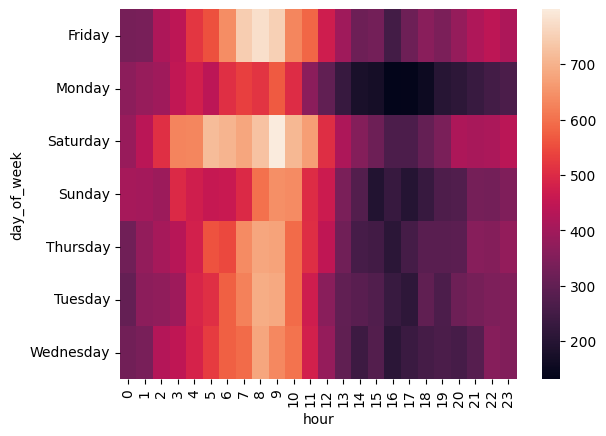

In [39]:
sns.heatmap(df_heatmap)

Examine daily activity
How patrons made deposits in a day 
and what were the values
Plot the results

In [40]:
df_working.columns

Index(['user', 'date', 'type', 'amount', 'hour', 'day_of_week'], dtype='object')

In [41]:
daily_activity = df_working.groupby(['user', 'date']) \
    .agg({'amount': 'sum', 'type': 'count'}) \
        .reset_index()
        
daily_activity

,user,date,amount,type
0,1,2019-03-01 17:24:43+00:00,30.00,1
1,1,2019-03-01 19:54:04+00:00,50.00,1
2,1,2019-03-01 22:44:15+00:00,40.00,1
3,1,2019-03-02 02:44:20+00:00,100.00,1
4,1,2019-03-02 18:28:39+00:00,25.00,1
...,...,...,...,...
69680,997,2019-09-22 00:56:47+00:00,50.00,1
69681,998,2019-11-09 07:03:51+00:00,25.00,1
69682,998,2019-11-09 07:05:05+00:00,25.00,1
69683,999,2019-03-20 10:58:04+00:00,250.00,1


In [42]:
daily_activity[daily_activity.user=="customer1"][0:20]

daily_activity

,user,date,amount,type
0,1,2019-03-01 17:24:43+00:00,30.00,1
1,1,2019-03-01 19:54:04+00:00,50.00,1
2,1,2019-03-01 22:44:15+00:00,40.00,1
3,1,2019-03-02 02:44:20+00:00,100.00,1
4,1,2019-03-02 18:28:39+00:00,25.00,1
...,...,...,...,...
69680,997,2019-09-22 00:56:47+00:00,50.00,1
69681,998,2019-11-09 07:03:51+00:00,25.00,1
69682,998,2019-11-09 07:05:05+00:00,25.00,1
69683,999,2019-03-20 10:58:04+00:00,250.00,1


In [43]:
c1 = daily_activity[daily_activity.user == '1'][0:20]
c1

,user,date,amount,type
0,1,2019-03-01 17:24:43+00:00,30.00,1
1,1,2019-03-01 19:54:04+00:00,50.00,1
2,1,2019-03-01 22:44:15+00:00,40.00,1
3,1,2019-03-02 02:44:20+00:00,100.00,1
4,1,2019-03-02 18:28:39+00:00,25.00,1
5,1,2019-03-03 03:35:28+00:00,100.00,1
6,1,2019-03-03 18:13:42+00:00,100.00,1
7,1,2019-03-04 02:06:51+00:00,60.00,1
8,1,2019-03-04 02:41:59+00:00,50.00,1
9,1,2019-03-04 07:39:37+00:00,50.00,1


looking at customer 1 there are gaps in the time line 
where this customer was not active
This gap will not let us plot the data
Create new df for customer 1 and fill in the gaps

In [44]:
user_1_df = daily_activity[daily_activity.user == '1']
user_1_df

,user,date,amount,type
0,1,2019-03-01 17:24:43+00:00,30.00,1
1,1,2019-03-01 19:54:04+00:00,50.00,1
2,1,2019-03-01 22:44:15+00:00,40.00,1
3,1,2019-03-02 02:44:20+00:00,100.00,1
4,1,2019-03-02 18:28:39+00:00,25.00,1
...,...,...,...,...
439,1,2020-02-14 23:52:49+00:00,50.00,1
440,1,2020-02-15 08:25:20+00:00,30.00,1
441,1,2020-02-15 18:37:41+00:00,20.00,1
442,1,2020-02-15 21:17:59+00:00,20.00,1


In [45]:
full_customer_df = pd.DataFrame()

for customer_id in daily_activity.user.unique():
    customer_df = daily_activity[daily_activity\
        .user == customer_id]
    
    full_range = pd.date_range(customer_df.date.min(),
                           customer_df.date.max(), freq='D')
    
    customer_df = customer_df.set_index(keys = 'date')
    
    customer_df = customer_df.reindex(list(full_range), 
                                      fill_value=0)
    customer_df.user = [customer_id]*len(customer_df)
    
    customer_df = customer_df.reset_index()
    full_customer_df = pd.concat([full_customer_df, customer_df])
    
full_customer_df = full_customer_df.reset_index(drop=True)

In [46]:
full_customer_df

,date,user,amount,type
0,2019-03-01 17:24:43+00:00,1,30.00,1
1,2019-03-02 17:24:43+00:00,1,0.00,0
2,2019-03-03 17:24:43+00:00,1,0.00,0
3,2019-03-04 17:24:43+00:00,1,0.00,0
4,2019-03-05 17:24:43+00:00,1,0.00,0
...,...,...,...,...
164079,2019-09-11 09:31:02+00:00,996,0.00,0
164080,2019-09-12 09:31:02+00:00,996,0.00,0
164081,2019-09-22 00:56:47+00:00,997,50.00,1
164082,2019-11-09 07:03:51+00:00,998,25.00,1


Work up a Sankey plot

In [47]:
full_customer_df['month'] = full_customer_df.date.dt.\
    to_period('M')

customer_month = full_customer_df.groupby(['month', 'user']) \
    .count().reset_index().iloc[:, :2]
    
start_ = customer_month.groupby('user').min().reset_index()

end_ = customer_month.groupby('user').max().reset_index()

start_end_df = pd.merge(start_, end_, on='user')

start_end_df


/tmp/ipykernel_29170/1831215148.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  to_period('M')


,user,month_x,month_y
0,1,2019-03,2020-02
1,10,2019-03,2020-02
2,100,2019-06,2020-02
3,1000,2019-05,2019-05
4,1001,2019-07,2020-02
...,...,...,...
2275,995,2019-05,2020-02
2276,996,2019-03,2019-09
2277,997,2019-09,2019-09
2278,998,2019-11,2019-11


In [48]:
source_target_value = start_end_df.groupby(['month_x', 'month_y']) \
    .count().reset_index()

In [49]:
source_target_value

,month_x,month_y,user
0,2019-03,2019-03,278
1,2019-03,2019-04,57
2,2019-03,2019-05,49
3,2019-03,2019-06,32
4,2019-03,2019-07,27
...,...,...,...
73,2019-12,2020-01,17
74,2019-12,2020-02,30
75,2020-01,2020-01,135
76,2020-01,2020-02,37


Use LabelEncoder to get data into shape for Sankey plot

In [50]:
le = LabelEncoder()
le.fit_transform(source_target_value.month_x.unique())

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [52]:
fig = go.Figure(data=[go.Sankey(node=dict(
    pad=100,
    thickness = 10,
    line = dict(color = 'gray', width = 0.5),
    label = ['Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug',
            'Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb' ],
    color = 'orange'),
                  link = dict(
                      source = le.transform(source_target_value.month_x.tolist()),
                      target = le.transform(source_target_value.month_y.tolist()),
                      value = source_target_value.user.tolist(),
                      #hovercolor=['black']
))])

fig.update_layout(title_text="Customer Lifetime: Mar - Feb",
                  font_size=10)
fig.show()